In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import os

from utils.image_helpers import plot_image_grid, get_images, load_image, rgb2gray, show_images, image_to_tensor, tensor_to_image
from simulation.Simulation import Simulation
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    print("num GPUs",torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
from models.trained_models.unet_wavelet import UNetWavelet
from torchsummary import summary

path = 'models/trained_models/unet_magintude_pffact_8_snrlog0-5_nlayers_10.pt'
trained_model = UNetWavelet(in_ch=1, out_ch=1)
trained_model.load_state_dict(torch.load(path))
trained_model = trained_model.type(dtype)
trained_model = trained_model.eval()
for param in trained_model.parameters():
    param.requires_grad = False

Number of Images: 10000 in data/imagenet_v2_top_images
(256, 256)


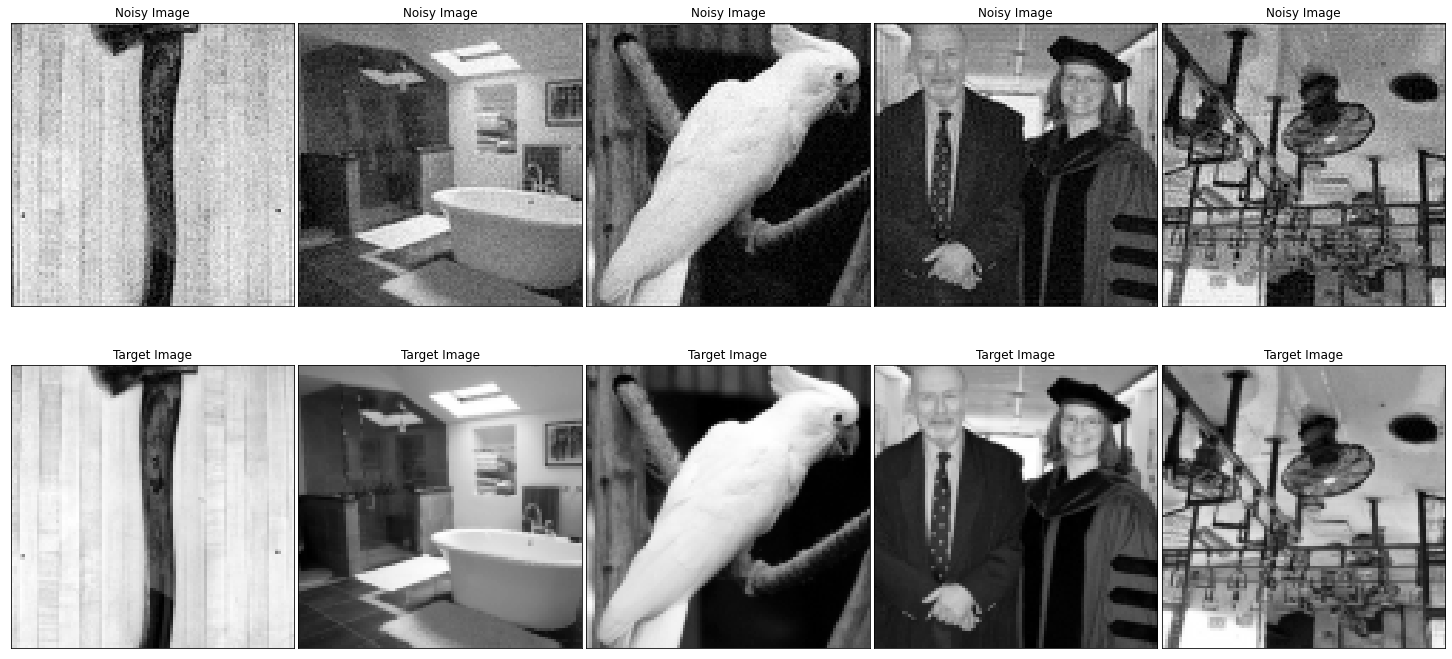

In [3]:
number_of_images = 5
original_images = get_images('data/imagenet_v2_top_images', max_amount=number_of_images)
image_dimensions = original_images[0].shape
print(image_dimensions)
cropped_size = (100, 100)

simulation = Simulation(input_size=image_dimensions, cropped_size=cropped_size, pf_factor=8, snr_range=(4,4))
noisy_images, target_images = simulation.simulate_list_of_images(original_images)

all_images = [x for row in zip(noisy_images, target_images) for x in row]
all_images = noisy_images + target_images
titles = ['Noisy Image'] * number_of_images + ['Target Image'] * number_of_images
plot_image_grid(all_images, titles, ncols=number_of_images)
plt.show()

In [4]:
trained_model_images = []
for noisy_image in noisy_images:
    noisy_tensor = image_to_tensor(noisy_image).unsqueeze(0).type(dtype)
    trained_image = trained_model(noisy_tensor)
    trained_model_image = tensor_to_image(trained_image.cpu().squeeze(0))
    trained_model_images.append(trained_model_image)

In [5]:
number_of_fittings = 20

fit_model_configuration = get_fit_model_configuration()
fit_model_configuration.image_dimensions = list(cropped_size) + [1]
fit_model_configuration.log_frequency = 100
fit_model_configuration.number_of_iterations = 3000
fit_model_configuration.convergence_check_length = None

fit_model_configuration.input_shape = [16, 16]
fit_model_configuration.number_of_layers = 5
fit_model_configuration.number_of_hidden_channels = 32
fit_model_configuration.save_losses = False
fit_model_configuration.find_best = False

print(fit_model_configuration)

image_dimensions: [100, 100, 1]  
result_path: data/results/  
model_type: deep  
input_shape: [16, 16]  
number_of_layers: 5  
number_of_hidden_channels: 32  
number_of_iterations: 3000  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  



In [6]:
model_images = []
fitter = create_fitter_from_configuration(fit_model_configuration)
for image_index, noisy_image in enumerate(noisy_images):
    model_run_images = []
    for run_index in range(number_of_fittings):
        model = create_model_from_configuration(fit_model_configuration)
        log_prefix = f'Image {image_index+1}/{number_of_images}, Run {run_index+1}/{number_of_fittings}; '
        fitter(model, noisy_image, log_prefix=log_prefix)
        model_run_images.append(fitter.get_best_image())
    model_images.append(np.mean(model_run_images, axis=0))

print('')
#print('Number of weights in Deep Decoder:', sum(p.numel() for p in model.parameters()))
#print('Number of image data points:', np.prod(noisy_image.shape))
print('Subspace size:', sum(p.numel() for p in model.parameters())/np.prod(noisy_image.shape)*100, '%')

Image 5/5, Run 20/20; Step: 03000, Loss: 0.002032
Subspace size: 54.72 %


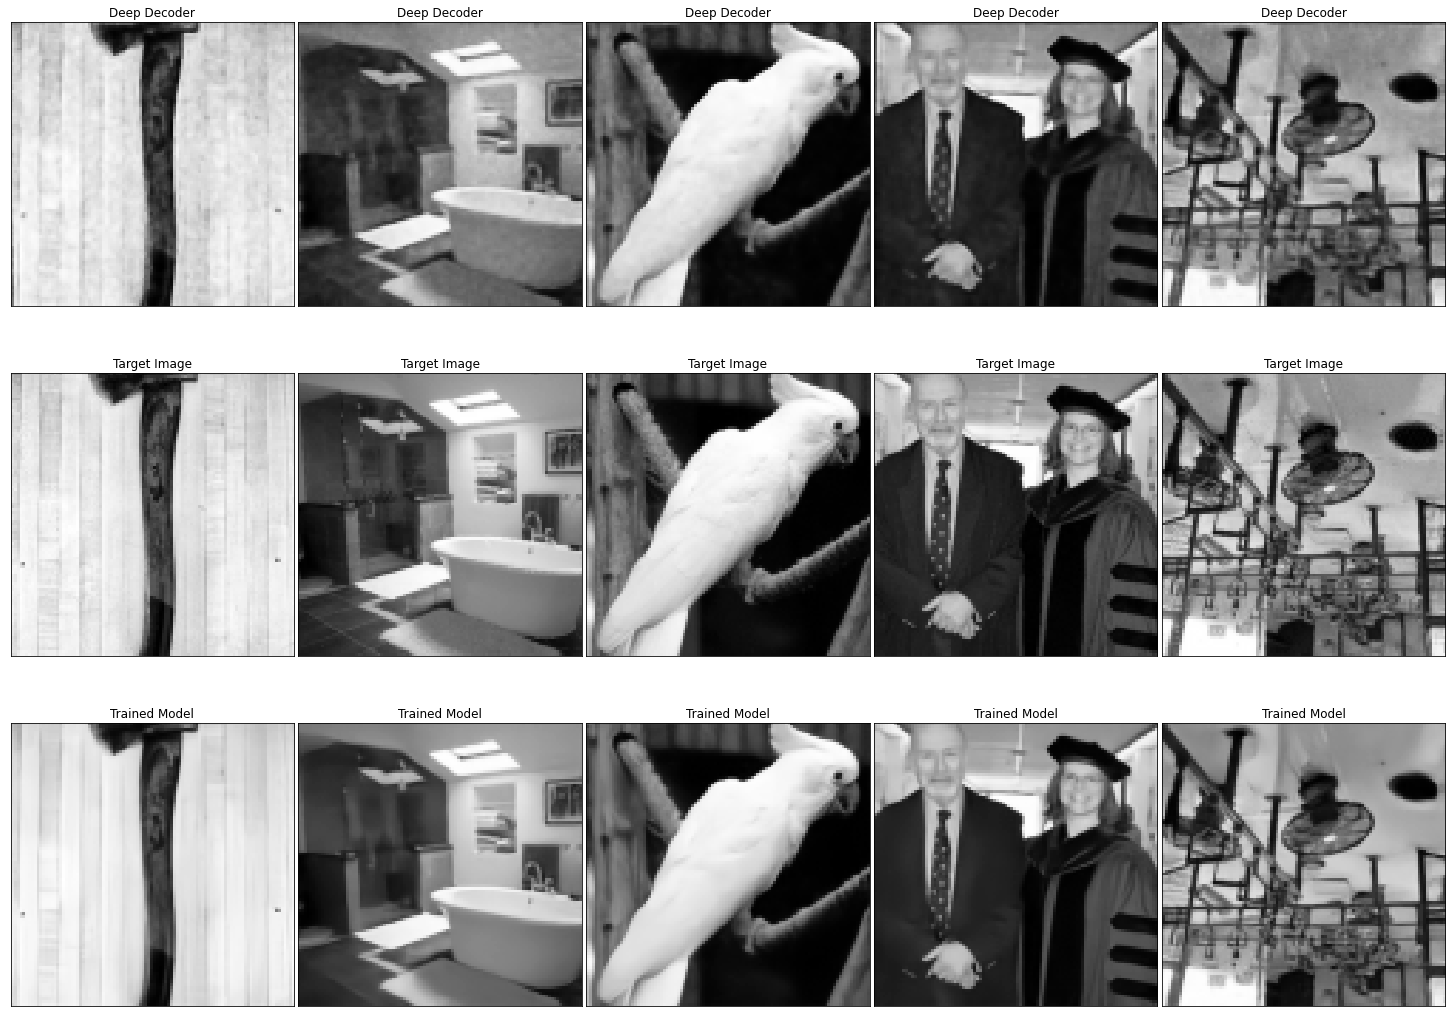

In [7]:
images = model_images + target_images + trained_model_images
titles = ['Deep Decoder'] * number_of_images + ['Target Image'] * number_of_images +['Trained Model'] * number_of_images
plot_image_grid(images, titles, ncols=number_of_images)
plt.show()